In [109]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)

# Experiment setup

In [409]:
def index_iter(n_dim, n_discr):
    """
    iterates through index tuples of n_dim dimentional cube with n_discr elements on each axis
    """
    powers = np.array([n_discr**i for i in range(n_dim)])
    powers_inc = n_discr*powers
    for i in range(n_discr**n_dim):
        yield ((i % powers_inc - i % powers)/powers).astype(np.int32)

        
def radial_fun(r,ri,sigma=0.15):
    return np.exp(-.5*(np.linalg.norm(r - ri)/sigma)**2)

class TaskSetup:
    def __init__(self, n_dim=3, n_discr=10, n_p=9, seed=42):
        """
        n_dim: dimentionality of the unit cube (equation domain), should be 3 for now
        n_discr: discretization of the unit cube
        n_p: number of radial functions
        """
        self.n_dim = n_dim
        self.n_discr = n_discr
        self.n_p = n_p
        self.discr_row = np.linspace(0, 1, n_discr)
        if seed is not None:
            np.random.seed(seed)
        
        # generate permability field
        self.ri = np.random.rand(n_p, n_dim) #centers of radial functions
        self.x = np.random.rand(n_p) #true parameters
        
        self.bi = np.zeros([n_p] + [n_discr]*n_dim) # radial functions 
        
        
        for i in range(n_p):
            for ind in index_iter(n_dim, n_discr):
                r = np.array([self.discr_row[i] for i in ind])
                val = radial_fun(r, self.ri[i])
                arr_ind = tuple(((k) for k in ind))
                self.bi[i][arr_ind] = val 
    
        self.K = self.eval_perm_field(self.x) # true permability field
        
        # generate sources
        self.Q = np.zeros([n_discr]*n_dim)
        for ind in index_iter(n_dim, n_discr):
            r = np.array([self.discr_row[i] for i in ind])
            val = 0
            for center in index_iter(n_dim, 2):
                center = center*0.4 + 0.3 # place sources in the corners 
                val += radial_fun(r, center, 0.05)
            arr_ind = tuple(((k) for k in ind))
            self.Q[arr_ind] = val 
    
    def eval_perm_field(self, x):
        return np.tensordot(self.bi, x, ((0),(0)))
    
    def eval_u_x(self, x, u):
        K = self.eval_perm_field(x)
        phi = [K*grad for grad in np.gradient(u)]
        return sum([np.gradient(elem, axis=i) for i, elem in enumerate(phi)]) + self.Q
    
    def basis_projection_solution(self, x, U):
        """
        U supposed to be the list of previously calculated u values of shape (n_discr x n_discr x ...)
        """
        K = self.eval_perm_field(x)
        A = []
        for u in U:
            phi = [K*grad for grad in np.gradient(u)]
            new_vec = sum([np.gradient(elem, axis=i) for i, elem in enumerate(phi)])
            A.append(new_vec.flatten())
        U = np.vstack(U)
        A = U.T @ np.vstack(A).T
        b = U @ self.Q.flatten()
        coeffs = np.linalg.lstsq(A, b)
        return coeffs

In [410]:
task = TaskSetup(2, 40, 8)

Text(0.5, 1.0, 'true sources field')

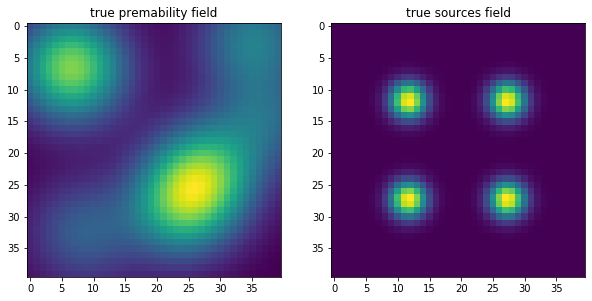

In [411]:
_, (ax1, ax2) = plt.subplots(1, 2)
ret = ax1.imshow(task.K); ax1.set_title('true premability field')
ax2.imshow(task.Q); ax2.set_title('true sources field')

In [412]:
task.eval_u_x(np.random.rand(len(task.x)), np.random.rand(*task.K.shape)).shape

(40, 40)

In [419]:
from scipy.optimize import minimize

def opt(u):
#     print('here ', opt.i)
#     opt.i += 1
    u = u.reshape(*task.K.shape)
    res = np.linalg.norm(task.eval_u_x(task.x, u))
    return res

# opt.i = 0

In [ ]:
res = minimize(opt, np.random.rand(np.prod(task.K.shape)), options={'maxiter': 1000, 'disp': True})
res

# Basis orthogonalization

In [277]:
def orthonormal(vectors):
    """
    turn list of vectors to basis vectors
    """
    Q = np.vstack(vectors).T
    Q, _ = np.linalg.qr(Q)
    vectors = (Q / np.linalg.norm(Q, axis=0)).T
    return vectors

n_vec = 3
n_dim = 5
X = list(np.random.rand(n_vec, n_dim))
q = orthonormal(X) 
assert np.allclose(np.linalg.norm(q, axis=1), np.ones(n_vec))
assert np.allclose(np.diag(q @ q.T), np.ones(n_vec))
# print(np.linalg.norm(q, axis=1), np.diag(q @ q.T))

# Metropolis–Hastings algorithm

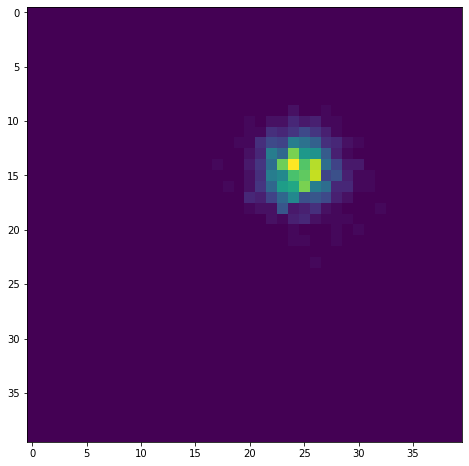

In [385]:
from scipy.stats import norm
from functools import partial

def normal_sampler(x, n_discr, sigma=.1):
    ret = []
    for ind in x:
        new_ind = norm.ppf(np.random.random(1), loc=ind, scale=sigma*n_discr).astype(int)   
        ret.append(np.clip(new_ind[0], 0, n_discr-1))
    return np.array(ret)
    
if task.n_dim == 2:
    X = np.zeros_like(task.K)
    x = np.array([15, 25])
    f = partial(normal_sampler, n_discr=task.n_discr, sigma=0.05)

    for _ in range(1000):
        x_new = f(x)
        ind1, ind2 = x_new
        X[ind1, ind2] += 1

    plt.imshow(X)

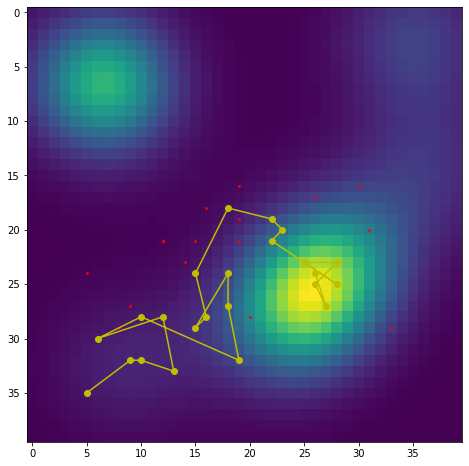

23 17


KeyboardInterrupt: 

In [399]:
from IPython.display import clear_output
from time import sleep

def metropolis_step(x, pi, q):
    """
    x: previous x (expected to be array of indexes)
    pi: pi(r), estimated distribution
    q: q(), sampling function, assumed to be symmetric
    
    returns: new_x (array of indexes), bool value (True if accepted)
    """
    new_x = q(x)
    old_ind = tuple(((k) for k in x))
    new_ind = tuple(((k) for k in new_x))
    alpha = min(1, pi[new_ind]/pi[old_ind])
#     print(alpha)
    if np.random.rand() < alpha:
        return new_x, True
    else:
        return new_x, False

if task.n_dim == 2:
    pi = task.K**2 
    x = np.array([35, 5])
    accepted = [x]
    rejected = []
    for _ in range(100):
        f = partial(normal_sampler, n_discr=task.n_discr, sigma=0.1)
        x_new, res = metropolis_step(x, pi, f)
#         x_new, res = f(x), True
        if res:
            accepted.append(x_new)
            x = x_new
        else:
            rejected.append(x_new)
            
        plt.imshow(pi)
        if len(accepted) > 2:
            accepted_ = np.array(accepted)
            
            plt.plot(accepted_[:,1], accepted_[:,0], 'yo-')
#             plt.plot(accepted_[:,1], accepted_[:,0], 'y')
        if len(rejected) > 2:
            rejected_ = np.array(rejected)
            plt.scatter(rejected_[:,1], rejected_[:,0], color='r', s=3)
        clear_output()
        plt.show()
        print(len(accepted), len(rejected))
        sleep(1)

In [402]:
np.gradient(np.random.rand(3, 3, 3))[0].shape

(3, 3, 3)